# Úkol č. 2 - předzpracování dat a binární klasifikace (do 2. listopadu 23:59)

  * V rámci tohoto úkolu se musíte vypořádat s příznaky, které jsou různých typů.
  * Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru **data.csv** a data na vyhodnocení v souboru **evaluation.csv**.

#### Seznam příznaků:
* survived - zda přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * V Jupyter notebooku načtěte data ze souboru **data.csv**. Vhodným způsobem si je rozdělte na podmnožiny vhodné k trénování modelu.
  * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
  * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména. Některé příznaky můžete také úplně zahodit.
  * Nějakým způsobem se vypořádejte s chybějícími hodnotami.
  * Následně si vyberte vhodný klasifikační model z přednášek. Najděte vhodné hyperparametry a určete jeho přesnost (accuracy) na trénovací množině. Také určete jeho přesnost na testovací množině.
  * Načtěte vyhodnocovací data ze souboru **evaluation.csv**. Napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte **results.csv** soubor, ve kterém tyto predikce uložíte do dvou sloupců: ID, predikce přežití. Tento soubor nahrajte do repozitáře.
  * Ukázka prvních řádků souboru *results.csv*:
  
```
ID,survived
1000,0
1001,1
...
```

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * (až +4 body) Aplikujte všechny klasifikační modely z přednášek a určete (na základě přesnosti na validační množině), který je nejlepší. Přesnost tohoto nejlepšího modelu odhadněte pomocí křížové validace. K predikcím na vyhodnocovacích datech využijte tento model.
  * (až +4 body) Zkuste použít nějaké (alespoň dvě) netriviální metody doplňování chybějících hodnot u věku. Zaměřte na vliv těchto metod na přesnost predikce výsledného modelu. K predikcím na vyhodnocovacích datech využijte ten přístup, který Vám vyjde jako nejlepší.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte nejen Jupyter Notebook, ale i _csv_ soubor s predikcemi pro vyhodnocovací data (`results.csv`).
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni**

# Import

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Úprava dat
Příznak 'sex' jsem klasicky převedl na 0 a 1. Příznak 'embarked' je kategorický, proto jsem upravil pomocí metody one-hot encoding. Příznak 'name' jsem nahradil příznakem 'name_len'. Myslím, že např. bohatí lidé, by mohli mít delší jméno kvůli titulu. Příznaky 'sibsp' a 'parch' v podstatě vyjadřují to samé, proto jsem je nahradil pouze jejich součtem 'family'. Příznaky 'ticket' a 'cabin' jsem odstranil, protože si nemyslím, že mají na vysvětlovanou proměnnou nějaký vliv. Příznak 'home.dest' by vliv mít mohl, ale nenapadl mě žádný rozumný způsob zpracování. Proto jsem ho také smazal. Chybějící hodnoty v 'age' jsem nahradil průměrem.

In [2]:
def getData(file):
    data = pd.read_csv(file)
    data['sex'] = data['sex'].apply(lambda x: 1 if (x == 'male') else 0)
    data = pd.concat([data.drop(columns = ['embarked']), pd.get_dummies(data['embarked'], prefix = 'dum_embarked')], axis = 1)
    data['name'] = data['name'].apply(lambda x: len(x))
    data = data.rename(columns = {'name' : 'name_len'})
    data.insert(0, "family", 0, True)
    data['family'] = data['sibsp'] + data['parch']
    data = data.drop(columns = ['ticket', 'cabin', 'home.dest', 'sibsp', 'parch'])
    avg = data['age'].mean()
    data['age'] = data['age'].fillna(avg)
    data = data.fillna(-1)
    
    return data

In [3]:
data = getData('data.csv')
data = data.drop(columns = ['ID']) # Sloupec ID jsem odstranil až zde, protože při evaulaci bude potřeba.

display(data.head())
display(data.info())

family  survived  pclass  name_len  sex        age     fare  \
0       0         1       3        26    1  19.000000   8.0500   
1       0         1       2        25    0  40.000000  13.0000   
2       0         0       3        28    0  18.000000   6.7500   
3      10         0       3        21    1  29.342535  69.5500   
4       0         0       3        19    0  30.000000   8.6625   

   dum_embarked_C  dum_embarked_Q  dum_embarked_S  
0               0               0               1  
1               0               0               1  
2               0               1               0  
3               0               0               1  
4               0               0               1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   family          1000 non-null   int64  
 1   survived        1000 non-null   int64  
 2   pclass          1000 non-null   int64  
 3   name_len        1000 non-null   int64  
 4   sex             1000 non-null   int64  
 5   age             1000 non-null   float64
 6   fare            1000 non-null   float64
 7   dum_embarked_C  1000 non-null   uint8  
 8   dum_embarked_Q  1000 non-null   uint8  
 9   dum_embarked_S  1000 non-null   uint8  
dtypes: float64(2), int64(5), uint8(3)
memory usage: 57.7 KB


None

Rozdělení dat na vysvětlovanou proměnnou(sloupec 'survived') a příznaky

In [4]:
xData = data.drop(columns = 'survived')
yData = data['survived']
display(xData.head())
display(yData.head())

family  pclass  name_len  sex        age     fare  dum_embarked_C  \
0       0       3        26    1  19.000000   8.0500               0   
1       0       2        25    0  40.000000  13.0000               0   
2       0       3        28    0  18.000000   6.7500               0   
3      10       3        21    1  29.342535  69.5500               0   
4       0       3        19    0  30.000000   8.6625               0   

   dum_embarked_Q  dum_embarked_S  
0               0               1  
1               0               1  
2               1               0  
3               0               1  
4               0               1

0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: int64

Rozdělení dat na trénovací, validační a testovací. Nejprve jsem oddělil testovací data a zbytek rozdělil na trénovací a validační.

In [5]:
seed = 666
xTrainValid, xTest, yTrainValid, yTest = train_test_split(xData, yData, test_size = 0.25, random_state = seed)
xTrain, xValid, yTrain, yValid = train_test_split(xTrainValid, yTrainValid, test_size = 0.25, random_state = seed)
print("původní data")
display(xData.shape)
display(yData.shape)
print("trénovací data")
display(xTrain.shape)
display(yTrain.shape)
print("validační data")
display(xValid.shape)
display(yValid.shape)
print("testovací data")
display(xTest.shape)
display(yTest.shape)

původní data


(1000, 9)

(1000,)

trénovací data


(562, 9)

(562,)

validační data


(188, 9)

(188,)

testovací data


(250, 9)

(250,)

# Rozhodovací strom
Hledal jsem nejlepší hodnoty hyperparametrů 'max_depth' a 'criterion'. Pro 'max_depth' jsem zkoušel hodnoty v rozmezí od 1 do 30 a hodnoty 'entropy' a 'gini' pro 'criterion'. Vytvořil jsem všechny možné kombinace a vybral tu nejlepší.

In [6]:
param_grid = {
    'max_depth': range(1,31), 
    'criterion': ['entropy', 'gini']
}
param_comb = ParameterGrid(param_grid)

val_acc = []
train_acc = []
for params in param_comb:
    desTree = DecisionTreeClassifier(**params)
    desTree.fit(xTrain, yTrain)
    train_acc.append(metrics.accuracy_score(yTrain, desTree.predict(xTrain)))
    val_acc.append(metrics.accuracy_score(yValid, desTree.predict(xValid)))

In [7]:
plt.figure(figsize=(20,6))
plt.plot(train_acc,'or-')
plt.plot(val_acc,'ob-')
plt.xlabel('index kombinace hyperparametrů')
plt.ylabel('Přesnost')
plt.legend(['Trénovací', 'Validační'])

In [8]:
best_params = param_comb[np.argmax(val_acc)]
print('best parameters: '+ str(best_params))

best parameters: {'max_depth': 3, 'criterion': 'entropy'}


Pro nejlepší kombinaci hyperparametrů jsem určil trénovací a validační přesnost. Na testovacích datech jsem model nespouštěl, protože ho ještě budu porovnávat s dalšími modely. 

In [9]:
desTree = DecisionTreeClassifier(**best_params)
desTree.fit(xTrain, yTrain)
train_acc_tree = metrics.accuracy_score(yTrain, desTree.predict(xTrain))
valid_acc_tree = metrics.accuracy_score(yValid, desTree.predict(xValid))
print('train accuracy: {0:.6f}'.format(train_acc_tree))
print('valid accuracy: {0:.6f}'.format(valid_acc_tree))

train accuracy: 0.807829
valid accuracy: 0.856383


# Náhodný les
Hledal jsem nejlepší hodnoty hyperparametrů 'n_estimators' a 'max_depth'.

In [10]:
param_grid = {
    'n_estimators': range(1, 100, 5),
    'max_depth': range(1, 9)
}

param_comb = ParameterGrid(param_grid)

val_acc = []
for params in param_comb:
    forest = RandomForestClassifier(**params).fit(xTrain, yTrain)
    val_acc.append(metrics.accuracy_score(yValid, forest.predict(xValid)))

In [11]:
best_params = param_comb[np.argmax(val_acc)]
print('best parameters: '+ str(best_params))

best parameters: {'n_estimators': 51, 'max_depth': 6}


In [12]:
forest = RandomForestClassifier(**best_params)
forest.fit(xTrain, yTrain)
train_acc_forest = metrics.accuracy_score(yTrain, forest.predict(xTrain))
valid_acc_forest = metrics.accuracy_score(yValid, forest.predict(xValid))
print('train accuracy: {0:.6f}'.format(train_acc_forest))
print('valid accuracy: {0:.6f}'.format(valid_acc_forest))

train accuracy: 0.887900
valid accuracy: 0.851064


# Ada Boost
Hledal jsem nejlepší hodnoty hyperparametrů 'n_estimators' a 'learning_rate'.

In [13]:
param_grid = {
    'n_estimators': range(1,100,5),
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 1]
}

param_comb = ParameterGrid(param_grid)

val_acc = []
for params in param_comb:
    adaBoost = AdaBoostClassifier(**params).fit(xTrain, yTrain)
    val_acc.append(metrics.accuracy_score(yValid, adaBoost.predict(xValid)))

In [14]:
best_params = param_comb[np.argmax(val_acc)]
print('best parameters: '+ str(best_params))

best parameters: {'n_estimators': 16, 'learning_rate': 1}


In [15]:
adaBoost = AdaBoostClassifier(**best_params)
adaBoost.fit(xTrain, yTrain)
train_acc_ada = metrics.accuracy_score(yTrain, adaBoost.predict(xTrain))
valid_acc_ada = metrics.accuracy_score(yValid, adaBoost.predict(xValid))
print('train accuracy: {0:.6f}'.format(train_acc_ada))
print('valid accuracy: {0:.6f}'.format(valid_acc_ada))

train accuracy: 0.798932
valid accuracy: 0.851064


# KNN
Hledal jsem nejlepší hodnoty hyperparametrů 'n_neighbors', 'p' a 'distance'.

In [16]:
param_grid = {
    'n_neighbors' : range(1, 12),
    'p': range(1, 3),
    'weights': ['uniform', 'distance'],
}
param_comb = ParameterGrid(param_grid)

val_acc = []
for params in param_comb:
    KNN = KNeighborsClassifier(**params).fit(xTrain, yTrain)
    val_acc.append(metrics.accuracy_score(yValid, KNN.predict(xValid)))

In [17]:
best_params = param_comb[np.argmax(val_acc)]
print('best parameters: '+ str(best_params))

best parameters: {'weights': 'uniform', 'p': 1, 'n_neighbors': 7}


In [18]:
KNN = KNeighborsClassifier(**best_params)
KNN.fit(xTrain, yTrain)
train_acc_knn = metrics.accuracy_score(yTrain, KNN.predict(xTrain))
valid_acc_knn = metrics.accuracy_score(yValid, KNN.predict(xValid))
print('train accuracy: {0:.6f}'.format(train_acc_knn))
print('valid accuracy: {0:.6f}'.format(valid_acc_knn))

train accuracy: 0.791815
valid accuracy: 0.739362


# Porovnání modelů
Porovnal jsem výsledku jednotlivých modelů. Nejlépe vyšel rozhodovací strom. Ten jsem poté pomocí křížové validace otestoval na testovacích datech.

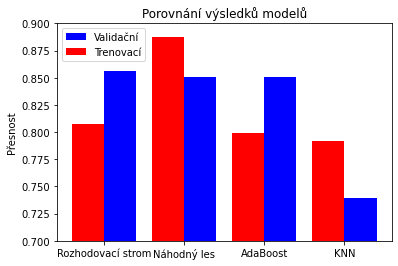

In [19]:
results_val = [valid_acc_tree, valid_acc_forest, valid_acc_ada, valid_acc_knn]
results_train = [train_acc_tree, train_acc_forest, train_acc_ada, train_acc_knn]

x_points_train = np.arange(len(results_val))
x_points_val = np.arange(0.4, len(results_val) + 0.4, 1)
x_points_labels = np.arange(0.2, len(results_val) + 0.2, 1)

plt.bar(x_points_val, results_val, label='Validační', color='b', width=0.4)
plt.bar(x_points_train, results_train, label='Trenovací', color='r', width=0.4)
plt.xticks(x_points_labels, ["Rozhodovací strom", "Náhodný les", "AdaBoost", "KNN"])
plt.ylim(0.7, 0.9)
plt.ylabel('Přesnost')
plt.title("Porovnání výsledků modelů")
plt.legend(loc = 2)
plt.show()

In [20]:
scores = cross_val_score(desTree, xTest, yTest, cv = 5)
print('test accuracy: {0:.6f}'.format(scores.mean()))

test accuracy: 0.784000


# Evaluace
Připravil jsem si evaluační data a pomocí nejlepšího modelu jsem pro ně zjistil vysvětlovanou proměnnou. Výsledky jsem zapsal do souboru.

In [21]:
evalut = getData('evaluation.csv')

survived = desTree.predict(evalut.drop(columns = ['ID']))
res = {'ID': evalut['ID'], 'survived': survived}
result = pd.DataFrame(res)
result.to_csv('results.csv', index=False)